In [1]:
import subprocess
import sys
import os
import shutil

try:
    import shap
    print("The 'shap' package is already installed.")
except ImportError:
    print("The 'shap' package is not installed. Attempting to install...")
    
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
        print("The 'shap' package has been successfully installed.")
    except subprocess.CalledProcessError:
        print("Failed to install the 'shap' package. Please try installing it manually.")

The 'shap' package is already installed.


In [2]:
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import shap
from keras.preprocessing import image
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import requests
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2
import keras

2024-07-22 05:40:47.008278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 05:40:47.008387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 05:40:47.150812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def retrieve_dataset_files(source_path='/kaggle/input/necesarios', destination_path='/kaggle/working'):
    # Ensure the destination directory exists
    os.makedirs(destination_path, exist_ok=True)
    
    # List all files in the source directory
    files = os.listdir(source_path)
    # Copy each file to the destination
    for file in files:
        source_file = os.path.join(source_path, file)
        destination_file = os.path.join(destination_path, file)
        shutil.copy2(source_file, destination_file)
        print(f"Copied: {file}")
    print("All files have been retrieved and copied to the destination.")
    
def array_show(array, title, cmap):
    plt.imshow(array, cmap)
    plt.title(title)
    plt.show()

retrieve_dataset_files()

Copied: tnc_54897705.jpg
Copied: morphology.py
Copied: evaluation.py
Copied: explanations.py
Copied: utils.py
Copied: synset_words.txt
Copied: goldfish.jpg
Copied: catdog.png
All files have been retrieved and copied to the destination.


In [4]:
model = ResNet50(weights="imagenet")
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
  1: bull_mastiff (Confidence score: 69.1%)
  2: boxer (Confidence score: 17.2%)
  3: tiger_cat (Confidence score: 6.62%)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.81s/it]               


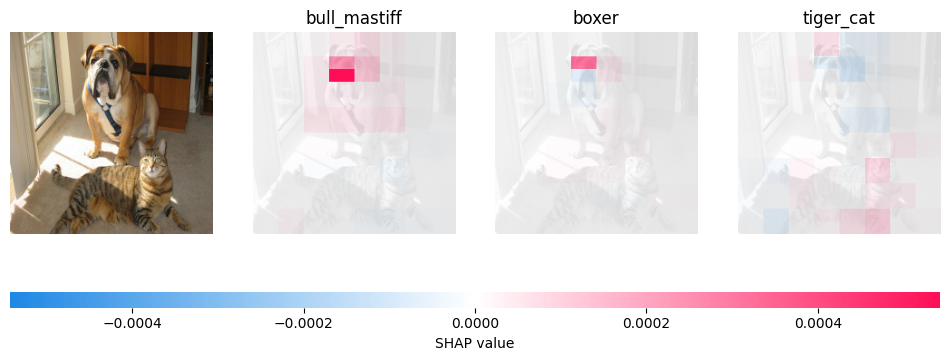

In [ ]:
def f(x):
    tmp = x.copy()
    tmp = preprocess_input(tmp)
    return model(tmp)

def load_img(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = 'catdog.png' 
img = load_img(image_path)
x = preprocess_input(img)
# Define the masker used to mask out partitions of the input image
masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))
predictions = f(img)

explainer = shap.Explainer(f, masker, output_names=class_names)
decoded_predictions = decode_predictions(predictions, top=3)

for i, (imagenet_id, class_name, score) in enumerate(decoded_predictions[0]):
    print(f"  {i+1}: {class_name} (Confidence score: {score * 100:.3}%)")
# Here we explain the image using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(img, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

shap.image_plot(shap_values, img)
# Decode the top 3 predictions to class names

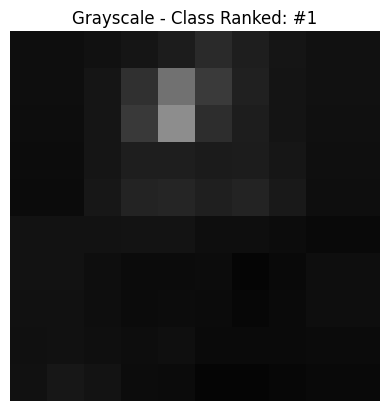

In [ ]:
extracted_values = shap_values.values
'''
At this point feel free to try out the Saliency Map of the first three classes, 
you can change the number of classes in 'Explanation.argsort.flip[:i]'
#1: bull_mastiff 2. boxer 3. tiger_cat
'''
rank = 0

class_name = decoded_predictions[0][rank][1]
heat_map = extracted_values[..., rank][0]

#We select the Shap Values from the class with the higher confidene score all three dimensions, this will give us an array with ((Input Size, 3)
normalized_heat_map = (heat_map - np.min(heat_map)) / (np.max(heat_map) - np.min(heat_map))
resized_img = cv2.resize(normalized_heat_map, (10, 10), interpolation=cv2.INTER_AREA)

def array_show(array, title, cmap):
    plt.imshow(array, cmap)
    plt.axis('off')
    plt.title(title)

array_show(resized_img,f"Grayscale - Class Ranked: #{rank+1}",'jet')
plt.show()

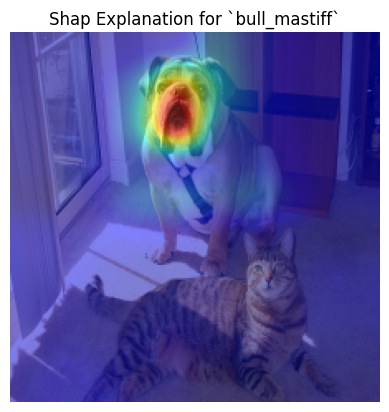

In [7]:
def saliency_map(img, heatmap,alpha=0.5):
    # Load the original image
    array_show(img[0],'Grayscale Heatmap for Class 1','jet')
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Create an image with RGB colorized heatmap
    
    #We need to fix below
    heatmap = keras.utils.array_to_img(heatmap)
    heatmap = heatmap.resize((224,224))
    heatmap = keras.utils.img_to_array(heatmap)
    #We need to fix above
    
    plt.title('Shap Explanation for `{}`'.format(class_name))
    plt.axis('off')
    plt.imshow(heatmap[:,:,0], cmap ='jet', alpha=0.5)
    plt.show()
    return  heatmap

sal = saliency_map(img, resized_img, rank)

In [8]:
from torch import nn
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter

from utils import *

HW = 224 * 224 # image area
n_classes = 1000

def gkern(klen, nsig):
    """Returns a Gaussian kernel array."""
    inp = np.zeros((klen, klen))
    inp[klen//2, klen//2] = 1
    k = gaussian_filter(inp, nsig)
    kern = np.stack([k, k, k])
    return kern.astype('float32')

def auc(arr):
    """Returns normalized Area Under Curve of the array."""
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)

def compute_correlation(score_var, all_sal_score_list):
    corr_list = []
    for i in range(len(score_var)):
        var_class_score = score_var[i][:,np.newaxis]
        sal_score = all_sal_score_list[i][:,np.newaxis]

        points = np.concatenate((var_class_score,sal_score),axis=-1)
        corr_list.append(np.corrcoef(points,rowvar=False)[0,1])

    corr_mean = np.array(corr_list)
    return corr_mean

def compute_calibration_metric(self, all_score_list, all_sal_score_list):
    if self.cumulative:
        score_var = all_score_list[:,:-1] - all_score_list[:,1:] 
    else:
        score_var = all_score_list[:,0:1] - all_score_list[:,1:]
        
    return compute_correlation(score_var, all_sal_score_list)

class CausalMetric():
    def __init__(self, model, mode, step, substrate_fn, model_type='tensorflow'):
        r"""Create deletion/insertion metric instance.

        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        assert mode in ['del', 'ins']
        self.model = model
        self.model_type = model_type
        self.mode = mode
        self.step = step
        self.substrate_fn = substrate_fn

    def single_run(self, img_tensor, explanation, verbose=0, save_to=None):
        if self.model_type == 'pytorch':
            img_tensor = img_tensor.cuda()
            pred = self.model(img_tensor)
            top, c = torch.max(pred, 1)
            c = c.cpu().numpy()[0]
        else:  # TensorFlow
            pred = self.model(img_tensor)
            top = tf.reduce_max(pred, axis=1)
            c = tf.argmax(pred, axis=1)[0].numpy()
            print(get_class_name(c))

        n_steps = (HW + self.step - 1) // self.step

        if self.mode == 'del':
            title = 'Deletion game'
            ylabel = 'Pixels deleted'
            start = img_tensor.clone() if self.model_type == 'pytorch' else tf.identity(img_tensor)
            finish = self.substrate_fn(img_tensor)
        elif self.mode == 'ins':
            title = 'Insertion game'
            ylabel = 'Pixels inserted'
            start = self.substrate_fn(img_tensor)
            finish = img_tensor.clone() if self.model_type == 'pytorch' else tf.identity(img_tensor)

        scores = np.empty(n_steps + 1)
        salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1), axis=-1)
        
        for i in range(n_steps + 1):
            if self.model_type == 'pytorch':
                pred = self.model(start)
                pr, cl = torch.topk(pred, 2)
            else:  # TensorFlow
                pred = self.model(start)
                pr, cl = tf.math.top_k(pred, k=2)

            scores[i] = pred[0, c].cpu().numpy() if self.model_type == 'pytorch' else pred[0, c].numpy()

            if i < n_steps:
                coords = salient_order[:, self.step * i:self.step * (i + 1)]
                if self.model_type == 'pytorch':
                    start.cpu().numpy().reshape(1, 3, HW)[0, :, coords] = finish.cpu().numpy().reshape(1, 3, HW)[0, :, coords]
                else:
                    start_np = start.numpy()
                    finish_np = finish.numpy()
                    start_np.reshape(1, 3, HW)[0, :, coords] = finish_np.reshape(1, 3, HW)[0, :, coords]
                    start = tf.convert_to_tensor(start_np)
                    
            # Render image if verbose, if it's the last step or if save is required.
            if verbose == 2 or (verbose == 1 and i == n_steps) or save_to:
                plt.figure(figsize=(10, 5))
                plt.subplot(121)
                plt.title('{} {:.1f}%, P={:.4f}'.format(ylabel, 100 * i / n_steps, scores[i]))
                plt.axis('off')

                plt.subplot(122)
                plt.plot(np.arange(i+1) / n_steps, scores[:i+1])
                plt.xlim(-0.1, 1.1)
                plt.ylim(0, 1.05)
                plt.fill_between(np.arange(i+1) / n_steps, 0, scores[:i+1], alpha=0.4)
                plt.title(title)
                plt.xlabel(ylabel)
                plt.ylabel(get_class_name(c))
                if save_to:
                    plt.savefig(save_to + '/{:03d}.png'.format(i))
                    plt.close()
                else:
                    plt.show()
        return scores

Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.


In [11]:
import torch
import tensorflow as tf
import numpy as np
from scipy.ndimage.filters import gaussian_filter

# Define constants
KLEN = 11  # or whatever value you prefer
NSIG = 5   # or whatever value you prefer

def gkern(klen, nsig):
    """Returns a Gaussian kernel array."""
    inp = np.zeros((klen, klen))
    inp[klen//2, klen//2] = 1
    k = gaussian_filter(inp, nsig)
    return k.astype('float32')

# Pre-compute the kernel
KERN = gkern(KLEN, NSIG)

def blur_image(x, model_type='pytorch'):
    if model_type == 'pytorch':
        # PyTorch implementation
        kern_torch = torch.from_numpy(KERN).unsqueeze(0).unsqueeze(0).repeat(3, 1, 1, 1)
        return torch.nn.functional.conv2d(x, kern_torch, padding=KLEN//2, groups=3)
    else:
        # TensorFlow implementation
        kern_tf = tf.convert_to_tensor(KERN)
        kern_tf = tf.expand_dims(tf.expand_dims(kern_tf, axis=-1), axis=-1)
        kern_tf = tf.repeat(kern_tf, 3, axis=2)  # Repeat for each channel
        
        # Ensure input has 3 channels
        if x.shape[-1] == 1:
            x = tf.repeat(x, 3, axis=-1)
        
        return tf.nn.depthwise_conv2d(x, kern_tf, strides=[1,1,1,1], padding='SAME')

# Use this function instead of a lambda
blur = lambda x: blur_image(x, model_type='tensorflow')

insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur, model_type='tensorflow')
deletion = CausalMetric(model, 'del', 224, substrate_fn=tf.zeros_like, model_type='tensorflow')

img_tensor = tf.convert_to_tensor(x, dtype=tf.float32)

# Get the max value
max_value = np.max(sal)
mean_value = np.mean(sal)
min_value = np.min(sal)
print("Max value:", max_value)
print("Mean value:", mean_value)
print("Mix value:", min_value)

Sparsity = max_value/mean_value #Before normalization

Snorm = (sal - min_value )/(max_value - min_value)
Smean = 1/np.mean(Snorm)

print(Smean)
hd = deletion.single_run(img_tensor, sal, verbose=1)
hi = insertion.single_run(img_tensor, sal, verbose=1)



sc3d = auc(hd)
sc3i = auc(hi)

Max value: 255.0
Mean value: 28.467693
Mix value: 0.0
8.957521462176288


Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.


In [ ]:
print(sc3d)
print(sc3i)

The correlation measured when masking the image is called Deletion Cor- relation (DC)
Linear correlation of the class score variations and the saliency scores


Once the scores ck have been computed, we compute the variation of the scores vk = ck − ck+1.

Finally, we compute the linear correlation between the vk and the sk where sk is the saliency score of the area masked at step k. For the IC metric, we take inspiration from IAUC, and instead of masking the image, we start from a blurred image, and gradually reveal the image according to the saliency map. Once the image is totally revealed, the score variations are computed vk = ck+1 − ck and we compute the linear correlation of the vk with the sk. Note that the order of the subtraction is reversed compared to DC because when revealing the image, the class score is expected to increase.
When computing DC/IC on a well-calibrated saliency method, we expect that when the class score variation is high, the saliency score should also be high, and conversely, when the class score variation is low, the saliency score should be also low.
The DC and IC metrics measure the calibration, which is an aspect that is ignored by the DAUC and IAUC metrics but also by the Sparsity metric. To illustrate, the DC and IC metrics are computed for the examples visible in fig. 3.
